## Analyse simulated motor profiles


In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import os

In [2]:
# Collect, unpickle, and combine data files
data_path = 'G:\\DATA\\SIM_RUNS'

# Find all files
files_all = [os.path.join(r,file) for r,d,f in os.walk(data_path) for file in f]

# Unpickle data files
RESULTS = pd.DataFrame()
for file in files_all:
    if '.data' in file:                
        infile = open(file,'rb')
        df = pickle.load(infile)
        RESULTS = RESULTS.append(df)
        infile.close
        print(file)        

G:\DATA\SIM_RUNS\2020-04-11__14-09-31\SIM_DYNEIN.data
G:\DATA\SIM_RUNS\2020-04-11__14-54-26\SIM_DYNEIN.data
G:\DATA\SIM_RUNS\2020-04-12__14-57-51\SIM_DYNEIN.data
G:\DATA\SIM_RUNS\2020-04-12__15-43-50\SIM_DYNEIN.data
G:\DATA\SIM_RUNS\2020-04-10__21-20-36\SIM_DYNEIN.data


In [3]:
RESULTS.head()

,Time,Lattice,Concentration,Length,Frametime,Type,Stepsize,Rates,Datestamp,Timestamp
0,"[8.66685584863308, 8.66685584863308, 8.6668558...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,40,1,SP,24,"[0.0025, 0.0138, 0.0138, 2.525]",2020-04-11,14:09:31
1,"[2.879619067826961, 2.879619067826961, 3.45616...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,40,1,SP,24,"[0.0025, 0.0138, 0.0138, 2.525]",2020-04-11,14:09:31
2,"[24.809818446181357, 24.809818446181357, 24.80...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,40,1,SP,24,"[0.0025, 0.0138, 0.0138, 2.525]",2020-04-11,14:09:31
3,"[2.9580224059112816, 2.9580224059112816, 3.475...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,40,1,SP,24,"[0.0025, 0.0138, 0.0138, 2.525]",2020-04-11,14:09:31
4,"[10.239383340530068, 10.239383340530068, 10.23...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,40,1,SP,24,"[0.0025, 0.0138, 0.0138, 2.525]",2020-04-11,14:09:31


In [4]:
# Investigate data set
print('Dynein types: ' + str(RESULTS.Type.unique()))
print('Lengths: ' + str(RESULTS.Length.unique()))
print('Concentrations: ' + str(RESULTS.Concentration.unique()))

Dynein types: ['SP']
Lengths: [40 60 80 100 120 140 160 180 200 220 240 260 280 300]
Concentrations: [1 2.5 4 1.5]


In [5]:
# Option to convolve the data with an experimentally determined PSF
convolve_data = True
step_size = 24

if convolve_data:
    # Microscope characteristics
    fwhm = 700  # width of the experimental Point Spread Function (in nm)
    sigma = (fwhm / 2.335) / step_size

    # Construct Gaussian filter
    sz = 100
    x = np.arange(-sz/2, (sz+1)/2)
    gauss_filter = np.exp(-x**2 / (2*sigma**2))
    gauss_filter = gauss_filter / np.sum(gauss_filter)

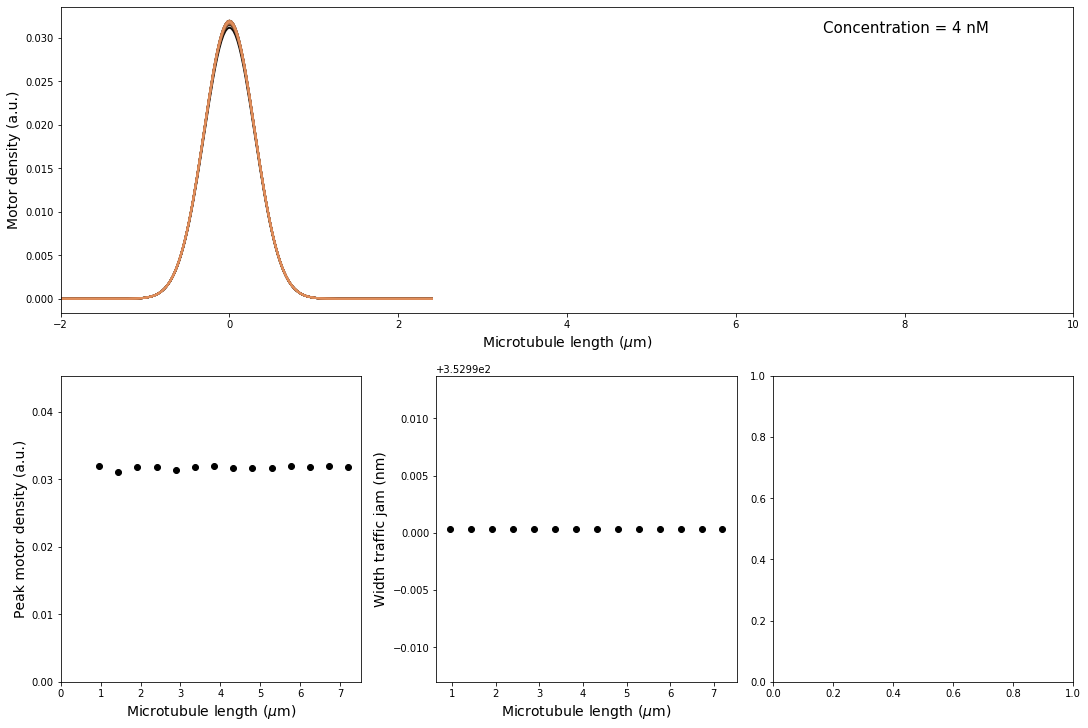

In [12]:
# Plot steady-state dynein profile for all lattice lengths

# Select concentration to plot
Concentration = 4

# Setup figure
fig = plt.figure(constrained_layout=True, figsize=(15 ,10))
spec = fig.add_gridspec(ncols=3, nrows=2)

lengths = RESULTS.Length.unique()
colors = [cm.copper(x) for x in np.arange(0, 256, len(lengths))]
Y_max = []
Y_width = []

ax = fig.add_subplot(spec[0, :])

for length, color in zip(lengths, colors):        
    
    # Prepare data
    data = RESULTS[RESULTS.Concentration.eq(Concentration) & RESULTS.Length.eq(length)].Lattice
    data = [data.iloc[x][-1] for x in range(len(data))]    
    
    if convolve_data:
        Y = np.mean(data, axis=0)   
        Y = np.concatenate((np.zeros(sz), Y, np.zeros(sz)), axis=None) 
        Y = np.convolve(Y, gauss_filter, 'same')
        X = np.arange(-sz, len(Y)-sz, 1) * (step_size/1000) 
    else:
        Y = np.mean(data, axis=0)  
        X = np.arange(0, len(Y), 1) * (step_size/1000)                
    
    Y_max.append(np.max(Y))
    
    # Calculate width (FWHM) of the traffic jam
    xvals = np.linspace(0, X[-1], len(X)*50)
    Y_interp = np.interp(xvals, X, Y)  
    fwhm_peak = np.where(Y_interp >= Y_max[-1]*0.5)[0]  
    Y_width.append(xvals[fwhm_peak[-1]] - xvals[fwhm_peak[0]])
    
    ax.plot(X, np.flip(Y), color=color, linewidth=2)        

ax.set_xlim((-2, 10))        
ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=14)
ax.set_ylabel('Motor density (a.u.)' , fontsize=14)
ax.text(9, np.max(Y_max), 'Concentration = '+ str(Concentration) + ' nM', 
        horizontalalignment='right', verticalalignment='top', fontsize = 15)


# Plot max intensity
ax = fig.add_subplot(spec[1,0])
ax.scatter(lengths*(step_size/1000), Y_max, c='black')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)   
ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=14)
ax.set_ylabel('Peak motor density (a.u.)' , fontsize=14)

# Plot FWHM of traffic jam
ax = fig.add_subplot(spec[1,1])
ax.scatter(lengths* (step_size/1000), np.multiply(Y_width,1000), c='black')
ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=14)
ax.set_ylabel('Width traffic jam (nm)' , fontsize=14)

# Plot plus-end slope
ax = fig.add_subplot(spec[1,2])


plt.show()

In [8]:
# Plot steady-state dynein profile for all lattice lengths

# Select parameters to plot
dynein_type = 'SP'
dynein_conc = RESULTS.Concentration.unique()

# Setup figure
fig = plt.figure(constrained_layout=True, figsize=(15 ,10))
ncols = 2
nrows = np.ceil(len(dynein_conc)/2)
spec = fig.add_gridspec(ncols=ncols, nrows=nrows)

lengths = RESULTS.Length.unique()
colors = [cm.copper(x) for x in np.arange(0, 256, len(lengths))]

for length, color in zip(lengths, colors):

    data = RESULTS[RESULTS.Concentration.eq(Concentration) & RESULTS.Length.eq(length)].Lattice
    data = [data.iloc[x][-1] for x in range(len(data))]    

    # Prepare data
    if convolve_data:
        Y = np.mean(data, axis=0)   
        Y = np.concatenate((np.zeros(sz), Y, np.zeros(sz)), axis=None) 
        Y = np.convolve(Y, gauss_filter, 'same')
        X = np.arange(-sz, len(Y)-sz, 1) * (step_size/1000) 
    else:
        Y = np.mean(data, axis=0)  
        X = np.arange(0, len(Y), 1) * (step_size/1000)
        
    ax.plot(X, np.flip(Y), color=color, linewidth=2)

ax.set_xlim((-2, 10))        
ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=13)
ax.set_ylabel('Motor density (a.u.)' , fontsize=13)

plt.show()

<Figure size 1080x720 with 0 Axes>